In [1]:
# Load the modules used

from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow
import tensorflow_hub as hub
from matplotlib import pyplot as plt

from datetime import datetime
import time

from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import tensorflow_hub as hub
from verstack.stratified_continuous_split import scsplit
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


## Processing the data

In [2]:
def word_cut(word):
    if pd.isna(word):
        return []
    word_array = np.array([])
    l = 0
    for i,s in enumerate(word):
        if s == ',':
            word_array = np.append(word_array, word[l:i])
            l = i+1
    word_array = np.append(word_array, word[l::])
    return word_array

In [3]:
def counter(word):
    if pd.isna(word):
        return 0
    number = 1
    for s in word:
        if s == ',':
            number += 1
    return number

In [4]:
def data_preprocess(df):
    df = pd.read_csv("data/train.csv")
    df["user_verified"] = df["user_verified"].astype(int)
    df['date']  =(df['timestamp']).astype(np.int64) // 10**3
    df["user_verified"] = df["user_verified"].astype(int)
    df['date']= pd.to_datetime(df['date'], unit='s')
    df["hour"] = df["date"].dt.hour
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month

    # 0 for Monday
    df["weekday"] = df["date"].dt.weekday

    # If the day is a weekend or not
    df["weekend"] = np.where(np.logical_or(df["weekday"] == 5, df["weekday"] == 6), 1, 0)
    df["friends_followers_ratio"] = df["user_friends_count"]/df["user_followers_count"]
    df["has_hashtags"] = np.where(pd.notnull(df["hashtags"]), 1, 0)
    df["has_mentions"] = np.where(pd.notnull(df["user_mentions"]), 1, 0)
    df["has_urls"] = np.where(pd.notnull(df["urls"]), 1, 0)

    df["number_of_urls"] = df["urls"].apply(counter)
    df["number_of_mentions"] = df["user_mentions"].apply(counter)
    df["number_of_hashtags"] = df["hashtags"].apply(counter)
    return df

## Load the Processed Data

In [4]:
train_data_raw = pd.read_csv("./data/partially_treated_train_data.csv" )

In [5]:
train_data_original = pd.read_csv("./data/train.csv")

In [5]:
train_data_raw.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,...,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags,urls_popularity,hashtags_popularity,mentions_popularity,mentions_max_followers,mentions_max_friends
0,0,1588696955143,0.0,0,68460,1101,1226,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
1,1,1588464948124,0.0,0,309,51,202,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
2,2,1588634673360,0.0,0,3241,1675,2325,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
3,3,1588433158672,0.0,0,32327,667,304,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
4,4,1588582751599,0.0,0,581,42,127,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN


In [6]:
train_data = data_preprocess(train_data_original)

In [7]:
train_data.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,...,month,weekday,weekend,friends_followers_ratio,has_hashtags,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags
0,0,1588696955143,0,0,68460,1101,1226,NaN,NaN,NaN,...,5,1,0,1.113533,0,0,0,0,0,0
1,1,1588464948124,0,0,309,51,202,NaN,NaN,NaN,...,5,6,1,3.960784,0,0,0,0,0,0
2,2,1588634673360,0,0,3241,1675,2325,NaN,NaN,NaN,...,5,0,0,1.388060,0,0,0,0,0,0
3,3,1588433158672,0,0,32327,667,304,NaN,NaN,NaN,...,5,5,1,0.455772,0,0,0,0,0,0
4,4,1588582751599,0,0,581,42,127,NaN,NaN,NaN,...,5,0,0,3.023810,0,0,0,0,0,0


## Select the training features

In [7]:
train_data_raw.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'date', 'hour', 'day', 'month',
       'weekday', 'weekend', 'friends_followers_ratio', 'has_hashtags',
       'has_mentions', 'has_urls', 'number_of_urls', 'number_of_mentions',
       'number_of_hashtags', 'urls_popularity', 'hashtags_popularity',
       'mentions_popularity', 'mentions_max_followers',
       'mentions_max_friends'],
      dtype='object')

In [15]:
training_features = [ 'retweet_count', 'user_verified',
                       'user_statuses_count', 'user_followers_count', 'user_friends_count','hour', 'day', 'month',
                       'weekday', 'weekend', 'friends_followers_ratio', 'has_hashtags',
                       'has_mentions', 'has_urls', 'number_of_urls', 'number_of_mentions',
                       'number_of_hashtags', 'urls_popularity', 'hashtags_popularity',
                       'mentions_popularity', 'mentions_max_followers',
                       'mentions_max_friends' ]

In [16]:
train_data = train_data_raw[training_features]

In [19]:
train_data = train_data.replace([np.inf, np.inf], 0)
train_data = train_data.fillna(0)

In [11]:
train_data.describe()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,hour,day,month,weekday,weekend,...,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags,urls_popularity,hashtags_popularity,mentions_popularity,mentions_max_followers,mentions_max_friends
count,665777.000000,665777.000000,6.657770e+05,6.657770e+05,6.657770e+05,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,...,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,665777.000000,5.429100e+04,5.429100e+04
mean,147.687398,0.133294,4.167295e+04,2.329881e+05,2.743131e+03,12.646503,4.067243,4.959878,2.983509,0.286012,...,0.081545,0.321549,0.330758,0.129498,0.192219,62055.176618,888.411818,8.950151,7.029292e+06,2.747307e+03
std,2972.051181,0.339892,9.848516e+04,2.442260e+06,1.725410e+04,7.030982,5.507782,0.196244,2.206916,0.451895,...,0.273671,0.467071,0.490239,0.558951,0.694312,105870.928890,4271.525566,118.361516,2.085563e+07,2.518922e+04
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,2.352000e+03,2.060000e+02,2.290000e+02,7.000000,1.000000,5.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,1.080400e+04,1.002000e+03,6.390000e+02,14.000000,3.000000,5.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,2.000000,0.000000,3.809900e+04,6.012000e+03,1.746000e+03,19.000000,5.000000,5.000000,5.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,242936.000000,0.000000,0.000000,7.892020e+05,7.020000e+02
max,942572.000000,1.000000,7.203222e+06,1.170640e+08,4.399078e+06,23.000000,30.000000,5.000000,6.000000,1.000000,...,1.000000,1.000000,5.000000,13.000000,18.000000,242936.000000,25490.000000,2239.000000,1.267528e+08,1.392825e+06


In [20]:
train_data.head()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,hour,day,month,weekday,weekend,...,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags,urls_popularity,hashtags_popularity,mentions_popularity,mentions_max_followers,mentions_max_friends
0,0.0,0,68460,1101,1226,16,5,5,1,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,0.0,0,309,51,202,0,3,5,6,1,...,0,0,0,0,0,0,0,0,0.0,0.0
2,0.0,0,3241,1675,2325,23,4,5,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,0.0,0,32327,667,304,15,2,5,5,1,...,0,0,0,0,0,0,0,0,0.0,0.0
4,0.0,0,581,42,127,8,4,5,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [21]:
train_data[train_data['retweet_count'] > 900000]

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,hour,day,month,weekday,weekend,...,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags,urls_popularity,hashtags_popularity,mentions_popularity,mentions_max_followers,mentions_max_friends
546442,942572.0,1,12256,25441659,133,13,4,5,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [22]:
train_data.isna().sum()

retweet_count              0
user_verified              0
user_statuses_count        0
user_followers_count       0
user_friends_count         0
hour                       0
day                        0
month                      0
weekday                    0
weekend                    0
friends_followers_ratio    0
has_hashtags               0
has_mentions               0
has_urls                   0
number_of_urls             0
number_of_mentions         0
number_of_hashtags         0
urls_popularity            0
hashtags_popularity        0
mentions_popularity        0
mentions_max_followers     0
mentions_max_friends       0
dtype: int64

### drop the rows with `NaN`

In [23]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'hour', 'day', 'month',
       'weekday', 'weekend', 'friends_followers_ratio', 'has_hashtags',
       'has_mentions', 'has_urls', 'number_of_urls', 'number_of_mentions',
       'number_of_hashtags', 'urls_popularity', 'hashtags_popularity',
       'mentions_popularity', 'mentions_max_followers',
       'mentions_max_friends'],
      dtype='object')

In [17]:
train_data.describe()

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,hour,day,month,weekday,weekend,friends_followers_ratio,has_hashtags,has_mentions,has_urls,number_of_urls,number_of_mentions,number_of_hashtags
count,664949.000000,664949.000000,6.649490e+05,6.649490e+05,6.649490e+05,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000,664949.000000
mean,147.864854,0.133460,4.172351e+04,2.332783e+05,2.746547e+03,12.647690,4.068020,4.959848,2.983378,0.285923,2.196596,0.108908,0.081600,0.321817,0.331013,0.129583,0.192349
std,2973.892555,0.340071,9.853563e+04,2.443767e+06,1.726456e+04,7.030958,5.509663,0.196316,2.206798,0.451853,7.568688,0.311523,0.273755,0.467174,0.490283,0.559090,0.694441
min,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.368000e+03,2.070000e+02,2.300000e+02,7.000000,1.000000,5.000000,1.000000,0.000000,0.238071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.083500e+04,1.006000e+03,6.410000e+02,14.000000,3.000000,5.000000,4.000000,0.000000,0.932579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,3.815400e+04,6.031000e+03,1.749000e+03,19.000000,5.000000,5.000000,5.000000,1.000000,1.900338,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,942572.000000,1.000000,7.203222e+06,1.170640e+08,4.399078e+06,23.000000,30.000000,5.000000,6.000000,1.000000,1915.000000,1.000000,1.000000,1.000000,5.000000,13.000000,18.000000


In [14]:
for col in train_data.columns:
    train_data = train_data[ pd.to_numeric(train_data[col], errors='coerce').notnull() ]

### Transform to `numpy.array`

In [24]:
data = np.array(train_data).astype(np.float)

In [25]:
data.shape

(665777, 22)

In [26]:
X = data[:, 1:]
y = data[:, 0]

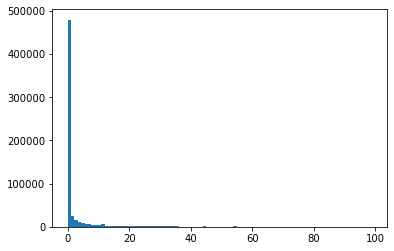

In [28]:
plt.hist(y[y<100], bins=90)
plt.show()

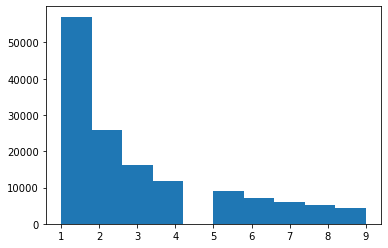

In [29]:
plt.hist(y[(0<y)*(y<10)], bins=10)
plt.show()

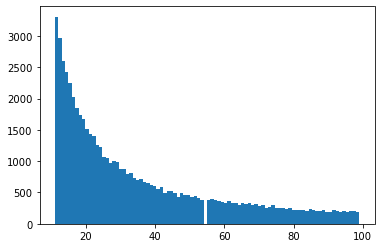

In [30]:
plt.hist(y[(10<y)*(y<100)], bins=90)
plt.show()

### Study of `y`: the retweet count

In [31]:
y.shape

(665777,)

In [32]:
y.max()

942572.0

In [26]:
y.min()

0.0

In [33]:
y.std()

2972.0489492028046

In [34]:
y.mean()

147.6873983330755

In [35]:
print("the count of y == 0: ", (y==0).sum())

the count of y == 0:  422803


In [36]:
print("the count of y in ]0, 10]: ", ((0 <  y) * (y < 10)).sum())

the count of y in ]0, 10]:  142546


In [37]:
print("the count of y in ]10, 100]: ", ((10 <  y) * (y < 100)).sum())

the count of y in ]10, 100]:  59400


In [38]:
print("the count of y in ]100, inf]: ", ((y > 100)).sum())

the count of y in ]100, inf]:  37163


In [257]:
print("the count of y in ]1000, inf]: ", ((y > 1000)).sum())

the count of y in ]1000, inf]:  10240


## Benchmark

- baseline: MAE ~ 280
- all zero prediction: MAE ~ 150

# Classification

In [46]:
clf_zoo = {  }

## Random Forest

In [39]:
y0 = (y > 0)

In [40]:
y0.sum()

242974

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## First Model: Classification, y = 0?

From the histgram and statistic value above, we found that the nealy 2/3 of the tweet have 0 retweet, so we want to start by trying to classify if the tweet has retweet or not.

In [42]:
y_train_0 = (y_train > 0)

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf_1 = RandomForestClassifier(max_depth=20, random_state=42).fit(X_train, y_train_0)

In [60]:
# Importance of features
clf_1.feature_importances_

array([2.42011193e-02, 9.30361032e-03, 7.07755355e-02, 7.93885449e-03,
       4.05201049e-03, 1.17956462e-03, 2.56440927e-04, 1.58138707e-03,
       1.79875350e-03, 3.11093906e-02, 4.30955549e-02, 1.51360783e-02,
       2.77151592e-01, 2.51995324e-01, 1.98968835e-02, 4.26249065e-02,
       1.68936903e-01, 1.83957526e-02, 4.95158891e-03, 3.25376329e-03,
       2.36498650e-03])

In [64]:
clf_zoo['base'] = clf_1

### performance on test set

In [61]:
prediction = clf_1.predict(X_test)

In [62]:
y_test_0 = (y_test > 0)

In [63]:
print( "f1 score: ", f1_score(prediction, y_test_0, average="macro") )
print( "accuracy: ", accuracy_score(prediction, y_test_0) )

f1 score:  0.9752035137343797
accuracy:  0.9772973054162035


We pick the threshold 0.03

## SVC

In [65]:
# Too slow

## Test the threshold

In [66]:
threshold = 0.03

prediction = clf_1.predict_proba(X_test)
y_pred_0 = (prediction[:,1] > threshold)

In [67]:
confusion_matrix(y_test_0, y_pred_0)

array([[64588, 20101],
       [  685, 47782]], dtype=int64)

In [74]:
(y_pred_0.shape[0] - y_pred_0.sum()) 

65273

Percentage of 0 predicted:

In [75]:
(y_pred_0.shape[0] - y_pred_0.sum())  / y_pred_0.shape[0]

0.4901994652888341

Cost 

In [69]:
wrong = []
for (pred, real) in zip(y_pred_0, y_test):
    if pred == 0 and real > 0:
        print(real)
        wrong.append(real)

141000.0
8402.0
1.0
843.0
1.0
1.0
36.0
1.0
18.0
1.0
7.0
29.0
2.0
2.0
4.0
2.0
1.0
1.0
1.0
12.0
2406.0
1.0
2.0
8.0
2.0
4.0
2.0
2.0
1.0
1.0
2.0
1921.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
61.0
1.0
2.0
8.0
1.0
1.0
1.0
45.0
1.0
2.0
3.0
5.0
10014.0
277.0
5.0
1.0
1.0
1106.0
7.0
1.0
1.0
1.0
3.0
28.0
2.0
1.0
16.0
3.0
1.0
5.0
2.0
5.0
1.0
6.0
1.0
1.0
1.0
1.0
5.0
11.0
145.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
1.0
3.0
3.0
4.0
1.0
72.0
1.0
1.0
1.0
1.0
1.0
1.0
19.0
2.0
1.0
1.0
1.0
6.0
1.0
6.0
10.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
69.0
1.0
1.0
1.0
2.0
2.0
272.0
1.0
6.0
1.0
10.0
15.0
2.0
1.0
1.0
5.0
1.0
1.0
2.0
1.0
4.0
2.0
2.0
1.0
1.0
2.0
1.0
1.0
153.0
1.0
1.0
1.0
1.0
4.0
3.0
4.0
567.0
1.0
2.0
1.0
558.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
1.0
2119.0
6.0
13.0
391.0
1.0
19.0
1.0
1.0
952.0
2.0
1.0
1.0
1.0
250.0
1.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
155.0
31.0
1.0
4.0
1.0
2.0
1.0
2.0
3.0
1.0
1.0
1.0
15.0
1.0
5.0
3.0
1.0
1.0
1.0
1.0
2413.0
1.0
1.0
1.0
1.0
2.0
781.0
9.0
11.0
1.0
1.0
2.0
3.0
1.0
2.0
1.0
516.0
2.0

In [70]:
wrong = np.array(wrong)

In [71]:
wrong.shape

(685,)

In [76]:
wrong.sum() / (y_pred_0.shape[0] - y_pred_0.sum()) 

8.103978674183812

**Just MAE of 8.7 on 60\% of data !**

## Remove the samples with classifier one `base` 's result being 0

In [77]:
X_train.shape

(532621, 21)

In [78]:
threshold = 0.03

prediction = clf_1.predict_proba(X_train)
mask = (prediction[:,1] > threshold)

In [79]:
y_train_1 = y_train[mask]
X_train_1 = X_train[mask]

In [80]:
X_train_1.shape

(265509, 21)

In [81]:
y_train_1.mean()

298.1359426610774

In [82]:
y_train_1.max()

942572.0

### Second model: int( log(y) )

classify the tweets by the order of the retweet count by int(log(y))

- 0-10: 0
- 11-100: 1
- 101-1000: 2
- 1001-10000: 3
- 10001-100000: 4
- 100001- $\infty$: 5

In [83]:
y_train_log = np.array(list(map( lambda x : int(np.log10(x)) if x > 0 else 0, y_train_1 )))

In [84]:
y_train_1

array([1.000e+00, 1.200e+01, 2.000e+00, ..., 0.000e+00, 4.854e+03,
       2.000e+00])

In [85]:
y_train_log

array([0, 1, 0, ..., 0, 3, 0])

In [86]:
y_test_log = np.array(list(map( lambda x : int(np.log10(x)) if x > 0 else 0, y_test )))

In [87]:
y_train_log.max()

5

In [88]:
y_train_log.mean()

0.45181519270533205

In [89]:
for i in range(6):
    print( "The number of class %d :"%i, len(y_train_log[y_train_log == i]) )

The number of class 0 : 185174
The number of class 1 : 50436
The number of class 2 : 21697
The number of class 3 : 6745
The number of class 4 : 1389
The number of class 5 : 68


We can see a exponential trend in the distribution 

We need balanced training features and labels

In [90]:
def get_train_data(i):
    X = []
    Y = []
    
    pos_count = 0
    neg_count = 0
    
    while pos_count < 1000:
        for x, y in zip(X_train_1, y_train_log):
            if y > i:
                X.append(x)
                Y.append(1)
                pos_count += 1
            elif pos_count + 1 > neg_count * 0.8 and np.random.rand() > 0.5:
                X.append(x)
                Y.append(0)
                neg_count += 1
    print("positive_sample: ", pos_count, "; negative sample: ", neg_count)
    return np.array(X), np.array(Y)

## Random Forest

In [91]:
max_depth = [22, 22, 20, 15, 15]

In [92]:
for i in range(2):
    X_train, y_train = get_train_data(i)
    clf = RandomForestClassifier(max_depth=max_depth[i], random_state=42).fit(X_train, y_train)
    clf_zoo[i] = clf 
    y_test_ = (y_test_log > i)
    
    print( "F1 in the test set: \n", f1_score( clf.predict(X_test), y_test_))
    print( "ACC in the test set: \n", accuracy_score( clf.predict(X_test), y_test_))
    print( "CM in the test set: \n", confusion_matrix( clf.predict(X_test), y_test_))

positive_sample:  80335 ; negative sample:  92624
F1 in the test set: 
 0.6342464605847365
ACC in the test set: 
 0.8688455646009192
CM in the test set: 
 [[100550   4941]
 [ 12523  15142]]
positive_sample:  29899 ; negative sample:  37375
F1 in the test set: 
 0.4377947885254774
ACC in the test set: 
 0.8907897503679895
CM in the test set: 
 [[112952   1777]
 [ 12765   5662]]
positive_sample:  8202 ; negative sample:  10254
F1 in the test set: 
 0.12112167151048622
ACC in the test set: 
 0.8319414821712878
CM in the test set: 
 [[109236    507]
 [ 21871   1542]]
positive_sample:  1457 ; negative sample:  1823
F1 in the test set: 
 0.014604128021670642
ACC in the test set: 
 0.7486632220853735
CM in the test set: 
 [[99441   105]
 [33362   248]]
positive_sample:  1020 ; negative sample:  1277
F1 in the test set: 
 0.0006824191759788451
ACC in the test set: 
 0.9120204872480399
CM in the test set: 
 [[121437     15]
 [ 11700      4]]


In [93]:
def get_classes_pos(x):
    res = np.zeros(6)
    p0 = clf_zoo['base'].predict_proba([x])[0,1]
    if p0 < 0.03:
        res[0] = 1
        return res
    for i in range(5):
        res[i+1] = clf_zoo[i].predict_proba([x])[0,1]
    return res

In [94]:
get_classes_pos(X_test[0])

array([0.        , 0.16414018, 0.1817707 , 0.06142857, 0.18157475,
       0.14      ])

In [95]:
y_test[0]

2.0

In [96]:
print(get_classes_pos(X_test[3]))
print(y_test[3])

[0.         0.96173993 0.57630779 0.28409503 0.6353251  0.07      ]
95.0


### Test the results

In [97]:
def validate_classfication(X_val, y_val, threshold, average):
    y_predict = np.zeros(y_val.shape[0])
    
    
    for (i, x) in enumerate(X_val):
        if (i % 2000 == 0):
            print("processed: ", i)
        p = get_classes_pos(x)
        if p[0] > 0:
            y_predict[i] = 0
        else:
            largest_class = 0
            for j in range(5):
                if p[j+1] >= threshold[j]:
                    largest_class = j+1
            y_predict[i] = 10**largest_class * average

    cost = np.abs(y_val - y_predict).mean()
    print("cost at ", threshold, ": ", cost)
    return cost, y_predict


In [102]:
threshold = [0.47092152, 0.55543368, 1,1,1]

In [201]:
optimal_threshold = [0.47092152, 0.55543368, 0.868192  , 0.76829936, 0.97466098]
optimal_cost = 142

In [101]:
X_val = X_test[10000:20000]
y_val = y_test[10000:20000]

In [103]:
y_predict = validate_classfication(X_val, y_val, threshold, 0.3)[1]

processed:  0
processed:  2000
processed:  4000
processed:  6000
processed:  8000
cost at  [0.47092152, 0.55543368, 1, 1, 1] :  147.88996


In [105]:
y_predict.mean()

3.4064399999999995

In [104]:
y_val.mean()

149.2856

In [89]:
experience_count = 0
while(experience_count < 20):
    threshold = np.array([0.47, 0.5, 0.5, 0.6, 0.6]) + \
                            np.array( [0 * np.random.rand(), 0 * np.random.rand(), 0.4 * np.random.rand(), 0.2 * np.random.rand(), 0.1 * np.random.rand() ])
    y_predict = np.zeros(y_val.shape[0])
#     threshold = optimal_threshold
    
    cost = validate_classfication(X_val, y_val, threshold, 0.3)[0]
    
    if cost < optimal_cost:
        optimal_cost = cost
        optimal_threshold = threshold
        optimal_y_predict = y_predict
    experience_count += 1

processed:  0
processed:  2000
processed:  4000
processed:  6000
processed:  8000
cost at  [0.47       0.5        0.75483704 0.62013479 0.69677265] :  142.16107
processed:  0
processed:  2000
processed:  4000
processed:  6000
processed:  8000
cost at  [0.47       0.5        0.53580803 0.73569267 0.6076013 ] :  149.78367999999998
processed:  0
processed:  2000
processed:  4000
processed:  6000


KeyboardInterrupt: 

optimal threshold value: [0.47092152, 0.55543368, 1, 1, 1]

In [373]:
optimal_threshold

array([0.47092152, 0.55543368, 0.868192  , 0.76829936, 0.97466098])

In [310]:
np.abs(y_predict[:10000] - y_test[:10000]).mean()

185.0507

In [106]:
sample = y_predict[:10000]

In [107]:
sample.mean()

3.4064399999999995

In [108]:
sample[:100]

array([ 0.3, 30. ,  0. ,  0. ,  0.3, 30. ,  0.3, 30. ,  0.3,  0.3,  0.3,
        0.3,  0. ,  0.3, 30. ,  0. ,  0.3,  0.3,  0. ,  0.3,  0. , 30. ,
        0. ,  0. ,  0.3,  0.3,  0.3,  0. ,  3. ,  0. ,  0.3,  0. ,  0. ,
        0. ,  0. ,  0.3,  0.3, 30. , 30. ,  0. ,  0.3,  0. ,  3. ,  3. ,
        0. ,  0. ,  0.3,  0. ,  0. ,  3. , 30. , 30. ,  0. , 30. ,  0. ,
        0.3, 30. ,  0. ,  0. ,  0. , 30. ,  0. ,  0. ,  0. ,  0.3,  0. ,
        3. ,  0. ,  0.3,  0.3,  0. , 30. , 30. ,  0.3,  3. ,  0.3,  0. ,
        0. ,  0.3,  0. ,  0.3,  3. ,  3. ,  0. ,  3. ,  0. ,  0.3,  0.3,
        0.3,  0. ,  0. ,  3. ,  3. ,  0. ,  0. ,  0. ,  0. ,  0. , 30. ,
        0. ])

In [109]:
y_val[:100]

array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
       8.8000e+01, 5.0000e+00, 5.2000e+01, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 4.0800e+02,
       0.0000e+00, 6.0000e+00, 2.6000e+02, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 6.7261e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 2.9000e+01, 0.0000e+00,
       5.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0600e+02, 1.0000e+00, 0.0000e+00,
       2.0000e+00, 5.0000e+00, 3.2800e+02, 3.5200e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e+01,
       2.4600e+02, 1.0000e+00, 0.0000e+00, 7.0000e+01, 0.0000e+00,
       2.0000e+00, 2.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       4.0950e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+01, 0.0000e+00, 1.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 7.0000e

In [110]:
sample.max()

30.0

## deep learning

In [192]:
def build_model_clf():
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=100000,
        decay_rate=0.99)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.binary_accuracy])
#     model.summary()
    return model

In [189]:
X_train, y_train = get_train_data(0)

positive_sample:  1040 ; negative sample:  1302


In [193]:
epochs = 30
batch_size = 1024
model_clf = build_model_clf()
model_clf.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=0.2, shuffle=True)

Train on 1873 samples, validate on 469 samples
Epoch 1/30
1873/1873 [==============================] - 1s 512us/sample - loss: 1.6230 - binary_accuracy: 0.5547 - val_loss: 0.6981 - val_binary_accuracy: 0.4435
Epoch 2/30
1873/1873 [==============================] - 0s 12us/sample - loss: 0.6950 - binary_accuracy: 0.4495 - val_loss: 0.6866 - val_binary_accuracy: 0.5565
Epoch 3/30
1873/1873 [==============================] - 0s 13us/sample - loss: 0.6751 - binary_accuracy: 0.5558 - val_loss: 1.0056 - val_binary_accuracy: 0.5565
Epoch 4/30
1873/1873 [==============================] - 0s 13us/sample - loss: 0.6390 - binary_accuracy: 0.6337 - val_loss: 2.1474 - val_binary_accuracy: 0.5565
Epoch 5/30
1873/1873 [==============================] - 0s 13us/sample - loss: 0.6057 - binary_accuracy: 0.6733 - val_loss: 0.7008 - val_binary_accuracy: 0.6098
Epoch 6/30
1873/1873 [==============================] - 0s 12us/sample - loss: 0.5477 - binary_accuracy: 0.7256 - val_loss: 1.6257 - val_binary_acc

In [182]:
for i in range(5):
    X_train, y_train = get_train_data(i)
    model_clf = build_model_clf()
    model_clf.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=0.2, shuffle=True)
    model_zoo[ ">10**%d"%i] = model_clf 
    y_test_ = (y_test_log > i)
    
    print( "F1 in the test set: \n", f1_score( clf.predict(X_test), y_test_))
    print( "ACC in the test set: \n", accuracy_score( clf.predict(X_test), y_test_))
    print( "CM in the test set: \n", confusion_matrix( clf.predict(X_test), y_test_))

positive_sample:  79837 ; negative sample:  99760
Train on 143677 samples, validate on 35920 samples
Epoch 1/30
143677/143677 [==============================] - 2s 16us/sample - loss: 0.5132 - binary_accuracy: 0.7439 - val_loss: 0.5085 - val_binary_accuracy: 0.7482
Epoch 2/30
143677/143677 [==============================] - 1s 9us/sample - loss: 0.4861 - binary_accuracy: 0.7601 - val_loss: 0.4725 - val_binary_accuracy: 0.7692
Epoch 3/30
143677/143677 [==============================] - 1s 9us/sample - loss: 0.4848 - binary_accuracy: 0.7613 - val_loss: 0.4737 - val_binary_accuracy: 0.7649
Epoch 4/30
143677/143677 [==============================] - 1s 9us/sample - loss: 0.4782 - binary_accuracy: 0.7636 - val_loss: 0.4721 - val_binary_accuracy: 0.7698
Epoch 5/30
143677/143677 [==============================] - 1s 9us/sample - loss: 0.4784 - binary_accuracy: 0.7626 - val_loss: 0.4690 - val_binary_accuracy: 0.7708
Epoch 6/30
143677/143677 [==============================] - 1s 9us/sample - lo

Epoch 19/30
53190/53190 [==============================] - 0s 9us/sample - loss: 0.4762 - binary_accuracy: 0.7685 - val_loss: 0.4642 - val_binary_accuracy: 0.7770
Epoch 20/30
53190/53190 [==============================] - 1s 9us/sample - loss: 0.4750 - binary_accuracy: 0.7705 - val_loss: 0.4749 - val_binary_accuracy: 0.7627
Epoch 21/30
53190/53190 [==============================] - 0s 9us/sample - loss: 0.4759 - binary_accuracy: 0.7681 - val_loss: 0.4856 - val_binary_accuracy: 0.7736
Epoch 22/30
53190/53190 [==============================] - 0s 9us/sample - loss: 0.4799 - binary_accuracy: 0.7676 - val_loss: 0.4683 - val_binary_accuracy: 0.7752
Epoch 23/30
53190/53190 [==============================] - 0s 9us/sample - loss: 0.4733 - binary_accuracy: 0.7705 - val_loss: 0.4643 - val_binary_accuracy: 0.7757
Epoch 24/30
53190/53190 [==============================] - 0s 9us/sample - loss: 0.4705 - binary_accuracy: 0.7743 - val_loss: 0.4692 - val_binary_accuracy: 0.7753
Epoch 25/30
53190/5319

1873/1873 [==============================] - 0s 18us/sample - loss: 0.2686 - binary_accuracy: 0.8927 - val_loss: 0.4426 - val_binary_accuracy: 0.7868
Epoch 26/30
1873/1873 [==============================] - 0s 17us/sample - loss: 0.3335 - binary_accuracy: 0.8548 - val_loss: 0.5467 - val_binary_accuracy: 0.7228
Epoch 27/30
1873/1873 [==============================] - 0s 17us/sample - loss: 0.3863 - binary_accuracy: 0.8441 - val_loss: 0.4766 - val_binary_accuracy: 0.7292
Epoch 28/30
1873/1873 [==============================] - 0s 18us/sample - loss: 0.3163 - binary_accuracy: 0.8681 - val_loss: 0.4936 - val_binary_accuracy: 0.7761
Epoch 29/30
1873/1873 [==============================] - 0s 17us/sample - loss: 0.2765 - binary_accuracy: 0.8783 - val_loss: 0.4501 - val_binary_accuracy: 0.7783
Epoch 30/30
1873/1873 [==============================] - 0s 16us/sample - loss: 0.2764 - binary_accuracy: 0.8729 - val_loss: 0.5044 - val_binary_accuracy: 0.7420
F1 in the test set: 
 0.0011419870574800

### Generally worse than Random Forest

# Regression Model

In [112]:
from sklearn.linear_model import LinearRegression

In [113]:
scaler = StandardScaler().fit(X)

In [114]:
X_train_1

array([[0.00000e+00, 1.94620e+04, 2.86000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 6.18800e+03, 2.98700e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 3.30000e+02, 1.13000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 6.14500e+03, 4.28600e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.01836e+05, 2.48189e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 2.87200e+03, 3.37800e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [118]:
def get_train_data_regr(i):
    """
    i in [0, 1,2,3]
    i = 0 ==> y in [0, 10]
    i = 1 ==> y in [10, 100]
    i = 2 ==> y in [100, inf]
    """
    
    X = []
    Y = []
    if i < 2:
        for x, y in zip(X_train_1, y_train_1):
            y_log =  int(np.log10(y)) if y > 0 else 0
            if y_log == i:
                X.append(x)
                Y.append(y)
    else:
        for x, y in zip(X_train_1, y_train_1):
            y_log =  int(np.log10(y)) if y > 0 else 0
            if y_log >= 2:
                X.append(x)
                Y.append(y)
        
    
    print("number of samples ", len(Y))
    return np.array(X), np.array(Y)

In [122]:
X_, y_ = get_train_data_regr(1)

number of samples  50436


In [123]:
y_

array([12., 37., 56., ..., 44., 38., 41.])

## Linear Regression

In [162]:
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import Ridge

In [164]:
regr_zoo = {}

for i in range(3):
    X_r, y_r = get_train_data_regr(i)
    X_train, X_val, y_train, y_val = train_test_split(X_r, y_r, test_size=0.2, random_state=42)
    regr = LinearRegression(normalize=True).fit(X_train, y_train)
    regr_zoo[i] = regr
    
    print("mae on validation set: ", np.abs(regr.predict(X_val) - y_val).mean())

number of samples  185174
mae on validation set:  1.268971786591297
number of samples  50436
mae on validation set:  18.494831651203626
number of samples  29899
mae on validation set:  3398.4941853853757


In [165]:
# Base regressor 

regr = LinearRegression().fit(X_train_1, y_train_1)
print("mae on validation set: ", np.abs(regr.predict(X_train_1) - y_train_1).mean())
regr_zoo[2] = regr

mae on validation set:  530.2997174124213


Very bad score

### Test on Test Data

In [238]:
def validate_regression(X_val, y_val, threshold):
    y_predict = np.zeros(y_val.shape[0])
    
    count = 0
    for (i, x) in enumerate(X_val):
        if (i % 2000 == 0):
            print("processed: ", i)
        p = get_classes_pos(x)
#         print(p)
        if p[0] > 0:
            y_predict[i] = 0
        else:
            largest_class = 0
            for j in range(2):
                if p[j+1] >= threshold[j]:
                    largest_class = j+1
            if largest_class == 2:
                count+= 1
            y_predict[i] = max( regr_zoo[largest_class].predict(np.array([x])).squeeze(), 0)

            
#             y_predict[i] = max( regr.predict([x])[0], 0)
            
    cost = np.abs(y_val - y_predict).mean()
    print("cost at ", threshold, ": ", cost)
    print(count)
    return cost, y_predict

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val = X_test[:10000]
y_val = y_test[:10000]

In [231]:
validate_regression(X_val, y_val, threshold)

processed:  0


IndexError: too many indices for array

In [148]:
y_val.mean()

151.6632

In [237]:
x = X_test[0]
max( model.predict(np.array([x])).squeeze(), 0)

array(2.9161904, dtype=float32)

## Random Forest Regressor

In [152]:
from sklearn.ensemble import RandomForestRegressor

In [263]:
regr_zoo = {}

for i in range(3):
    X_r, y_r = get_train_data_regr(i)
    X_train, X_val, y_train, y_val = train_test_split(X_r, y_r, test_size=0.2, random_state=42)
    regr = RandomForestRegressor(max_depth=10).fit(X_train, y_train)
    regr_zoo[i] = regr
    
    print("mae on validation set: ", np.abs(regr.predict(X_val) - y_val).mean())

number of samples  185174
mae on validation set:  1.1469462499898366
number of samples  50436
mae on validation set:  17.926101298331808
number of samples  29899
mae on validation set:  3035.5588778517194


In [264]:
# Base regressor 

regr = RandomForestRegressor(max_depth=10).fit(X_train_1, y_train_1)
print("mae on validation set: ", np.abs(regr.predict(X_train_1) - y_train_1).mean())
regr_zoo[2] = regr

mae on validation set:  408.29171275405116


In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val = X_test[:10000]
y_val = y_test[:10000]

validate_regression(X_val, y_val, threshold)

processed:  0
processed:  2000
processed:  4000
processed:  6000
processed:  8000
cost at  [0.47092152, 0.55543368, 1, 1, 1] :  165.58232495075643
1019


(165.58232495075643,
 array([3.38864043e+00, 1.32338926e-01, 0.00000000e+00, ...,
        3.64975534e-01, 5.32437904e+02, 0.00000000e+00]))

In [266]:
y_val.mean()

151.6632

**Slightly better than before, still worse than all-0 prediction**

## Deep Learning Regressor

The base regressor does not work well, we try to replace it by a deep learning regressor

In [267]:
def build_model():
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, 'relu'))
    
    model.compile(loss="mae", optimizer=optimizer, metrics=["mae"])
#     model.summary()
    return model

In [268]:
epochs = 10
batch_size = 512
model = build_model()
model.fit(X_train_1, y_train_1, epochs=epochs, batch_size = batch_size, validation_split=0.2, shuffle=True)

Train on 212407 samples, validate on 53102 samples
Epoch 1/10
212407/212407 [==============================] - 4s 20us/sample - loss: 290.1659 - mae: 290.1660 - val_loss: 303.0263 - val_mae: 303.0262
Epoch 2/10
212407/212407 [==============================] - 2s 12us/sample - loss: 288.7314 - mae: 288.7313 - val_loss: 300.1517 - val_mae: 300.1517
Epoch 3/10
212407/212407 [==============================] - 2s 12us/sample - loss: 287.8366 - mae: 287.8365 - val_loss: 299.3631 - val_mae: 299.3631
Epoch 4/10
212407/212407 [==============================] - 2s 12us/sample - loss: 286.4051 - mae: 286.4050 - val_loss: 300.2361 - val_mae: 300.2360
Epoch 5/10
212407/212407 [==============================] - 2s 12us/sample - loss: 286.3894 - mae: 286.3893 - val_loss: 299.2922 - val_mae: 299.2921
Epoch 6/10
212407/212407 [==============================] - 2s 12us/sample - loss: 285.8466 - mae: 285.8465 - val_loss: 307.4794 - val_mae: 307.4794
Epoch 7/10
212407/212407 [=============================

In [269]:
np.abs( model.predict(X_train_1).squeeze() - y_train_1 ).mean()

287.45823157818137

The error on train data is the closer to the mean

In [270]:
regr_zoo[2] = model

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val = X_test[:10000]
y_val = y_test[:10000]

validate_regression(X_val, y_val, threshold)

processed:  0
processed:  2000
processed:  4000
processed:  6000
processed:  8000
cost at  [0.47092152, 0.55543368, 1, 1, 1] :  147.83890364064425
1019


(147.83890364064425,
 array([3.38864043, 0.13233893, 0.        , ..., 0.36497553, 3.19536519,
        0.        ]))

## Reinforced Random Forest

In [241]:
def get_secondary_y(X, y, regr):
    """
        get the difference between the predict of the regr on X and y
    """
    return y - np.clip(regr.predict(X).squeeze(), 0, 10**7)

In [249]:
X.shape

(665777, 21)

In [182]:
X_train_1.shape

(265509, 21)

In [259]:
y_secondary = get_secondary_y(X_train_1, y_train_1, regr_zoo[2])

(array([   249.,    390.,    606.,   1322.,  74961., 135033.,  11345.,
          5964.,   3940.,   2862.]),
 array([-9.99849854e+01, -7.99890877e+01, -5.99931900e+01, -3.99972923e+01,
        -2.00013947e+01, -5.49697876e-03,  1.99904007e+01,  3.99862984e+01,
         5.99821960e+01,  7.99780937e+01,  9.99739914e+01]),
 <a list of 10 Patch objects>)

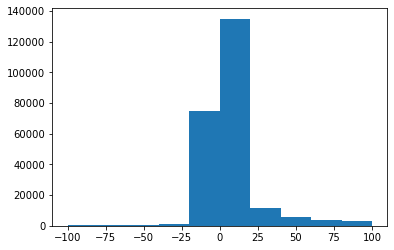

In [260]:
plt.hist(y_secondary[ np.abs(y_secondary) < 100])

In [261]:
y_secondary[ np.abs(y_secondary) < 1000].shape

(257572,)

In [262]:
y_secondary.shape

(265509,)

96 % examples' absolute values are below 1000. Good

### Secondary regressor: linear Regression

In [203]:
np.abs(y_secondary).mean()

407.005306585776

In [201]:
np.abs(regr.predict(X_train_1) - y_secondary).mean()

432.19795526993767

In [196]:
regr = LinearRegression().fit(X_train_1, y_secondary)

Worse than we don't have it

### Secondary regressor: Deep Learning

## Observe the prediction

In [149]:
y_predict.max()

30.0

In [150]:
y_predict.min()

0.0

In [151]:
np.abs(y_predict - y).mean()

ValueError: operands could not be broadcast together with shapes (10000,) (665777,) 

In [180]:
y_predict.mean()

160.45703709220447

(array([6.22521e+05, 3.40450e+04, 2.99500e+03, 1.66900e+03, 9.17000e+02,
        4.84000e+02, 5.71000e+02, 3.02000e+02, 2.10000e+02, 1.45000e+02,
        1.25000e+02, 5.40000e+01, 1.10000e+01, 4.80000e+01, 3.60000e+01,
        8.00000e+00, 8.00000e+00, 1.99000e+02, 2.56000e+02, 6.00000e+00,
        7.00000e+00, 2.10000e+01, 9.30000e+01, 6.00000e+00, 5.00000e+00,
        5.00000e+00, 0.00000e+00, 3.00000e+00, 9.00000e+00, 4.00000e+00,
        1.07000e+02, 4.10000e+01, 9.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 5.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.60000e+01]),
 array([    0.        ,   422.94720774,   845.89441549,  1268.84162323,
         1691.78883097,  2114.73603872,  2537.68324646,  2960.6304542 ,
         3383.57766195,  3806.52486969,  4229.47207743,  4652.41928518,
         5075.36649292,  5498.31370067,  5921.26090841,  6344.208

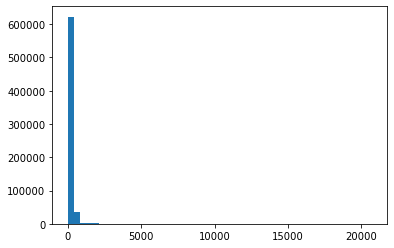

In [182]:
plt.hist(y_predict, bins=49)

In [183]:
regr.coef_

array([ 91.34859026, -94.75043562, 388.61893765,  44.04919105,
       -16.71411529, 262.77630995, 264.12108715,   7.51192508,
       -16.21918482, -29.82701817, -18.83204253, -24.85805737,
        83.52954733, -56.04407642,  -6.5297966 ,  -4.91947558])

In [395]:
def build_model():
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.95)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, 'relu'))
    
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
#     model.summary()
    return model

In [388]:
y_train.shape

(8114,)

In [398]:
y_train[:100]

array([ 1647.,  1767.,  8581.,  4273.,  1014.,  5650.,  9704.,  1342.,
        1263.,  4873.,  6107.,  2340., 35745.,  5011.,  2288.,  1121.,
        5846.,  4910., 16964.,  4822.,  1938.,  5387.,  3279.,  2789.,
        4917.,  3407.,  2457.,  1555.,  2545.,  7901., 12308.,  4434.,
        1670.,  1481.,  2500.,  1778.,  3020.,  1589.,  1474.,  7122.,
       13509., 30635.,  1084., 17341.,  2762.,  1063.,  2384.,  1034.,
        1026., 11042.,  1454.,  1259.,  4647.,  6878.,  1293.,  1595.,
        4191.,  1221.,  2608.,  1049.,  1784.,  3286.,  1887.,  2433.,
        8245.,  1956.,  2333.,  7230., 14286.,  4724.,  4123., 18770.,
       16629.,  1696.,  1086.,  2140.,  4399.,  3035., 10708.,  1865.,
        3868.,  8027.,  9972.,  7223.,  2163.,  1212.,  3116., 13196.,
        1173.,  3088.,  3339.,  2958.,  1913.,  1662.,  1060.,  1128.,
        7320.,  4499.,  3405.,  1497.])

In [397]:
epochs = 20
batch_size = 256
model = build_model()
X_train, y_train = get_train_data_regr(2)
model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=0.2, shuffle=True)

number of samples  8114
Train on 6491 samples, validate on 1623 samples
Epoch 1/20
6491/6491 [==============================] - 1s 206us/sample - loss: 532852645.7729 - mae: 8097.6880 - val_loss: 549426300.6285 - val_mae: 11397.0547
Epoch 2/20
6491/6491 [==============================] - 0s 26us/sample - loss: 503712518.3793 - mae: 8191.8618 - val_loss: 526856371.8546 - val_mae: 8933.3994
Epoch 3/20
6491/6491 [==============================] - 0s 26us/sample - loss: 501788697.7255 - mae: 8176.4209 - val_loss: 525298414.1762 - val_mae: 8482.9307
Epoch 4/20
6491/6491 [==============================] - 0s 26us/sample - loss: 501514196.7648 - mae: 8024.3525 - val_loss: 549978972.6087 - val_mae: 11903.4883
Epoch 5/20
6491/6491 [==============================] - 0s 25us/sample - loss: 499303160.0333 - mae: 8132.1084 - val_loss: 522806920.5767 - val_mae: 8620.9727
Epoch 6/20
5120/6491 [======================>.......] - ETA: 0s - loss: 542327694.7368 - mae: 8026.1812

KeyboardInterrupt: 

In [195]:
y_pred = model.predict(X_test_2).squeeze()

In [196]:
y_pred.sum()

17948044.0

In [197]:
(np.abs((y_pred - y_test_2))).mean()

192.7855864041011

In [198]:
y_pred

array([334.72394,   0.     ,   0.     , ...,   0.     , 205.2121 ,
         0.     ], dtype=float32)

In [199]:
y_test_2

array([  1., 192.,   0., ...,  10.,  41.,   0.])